In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import numpy
import torch.utils.data
from sklearn.model_selection import train_test_split

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('CPU is available')

CPU is available


# Display Dataset

In [3]:
import sys
sys.path.append('../..')
import seaborn as sns

from _datasets.LorenzAttractor import LorenzAttractor
from _datasets.MackeyGlassDataset import MackeyGlassDataset
from mpl_toolkits.mplot3d import Axes3D

attractor = LorenzAttractor(sample_len=10000, n_samples=10, 
                            xyz=[1.0, 1.0, 1.0], sigma=10.0, 
                            b=8/3, r=28.0, normalize=True, seed=42)

attractor_samp = attractor[0]

#* Normalize the sample
attractor_samp = (attractor_samp - attractor_samp.min()) / (attractor_samp.max() - attractor_samp.min())


# Plotting the Dataset

In [4]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=attractor_samp[:,0].numpy(), y=attractor_samp[:,1].numpy(), z=attractor_samp[:,2].numpy(),
    mode='lines',
    line=dict(color='blue', width=2)
)])

fig.update_layout(
    title='Lorenz Attractor Trajectory',
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    )
)

fig.show()

# Generating the model

In [5]:
from Models.Reservoir import Reservoir

In [6]:
inputs = attractor_samp[:-1,:].to(device)
targets = attractor_samp[1:,:].to(device)
print(inputs.shape)
print(targets.shape)

torch.Size([9999, 3])
torch.Size([9999, 3])


In [7]:
# Initialize ESN
ResLorenz = Reservoir(
    input_dim=3, 
    reservoir_dim=1000, 
    output_dim=3, 
    spectral_radius=0.95, 
    leak_rate=0.3, 
    sparsity=0.9, 
    input_scaling=0.5
)

ResLorenz.to(device)

Reservoir(
  (readout): Linear(in_features=1000, out_features=3, bias=True)
)

# Predictions

In [8]:
ResLorenz.train_readout(inputs, targets, Warmup=200)
predictions = ResLorenz.predict(inputs, steps=10000)
predictions = predictions.cpu().detach()

In [9]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure(data=[go.Scatter3d(
    x=predictions[:,0].numpy(), 
    y=predictions[:,1].numpy(), 
    z=predictions[:,2].numpy(),
    mode='lines',
    line=dict(
        color=predictions[:,2].numpy(),  # Color by z-value for depth
        colorscale='Viridis',            # Use a pretty colormap
        width=3,                         # Slightly thicker line
        showscale=True                   # Show color scale bar
    ),
    hoverinfo='none'                    # Cleaner hover
)])

# Update layout for better aesthetics
fig.update_layout(
    title={
        'text': 'Lorenz Attractor Trajectory',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, family='Arial')
    },
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis',
        xaxis=dict(gridcolor='rgb(200, 200, 200)', showbackground=True),
        yaxis=dict(gridcolor='rgb(200, 200, 200)', showbackground=True),
        zaxis=dict(gridcolor='rgb(200, 200, 200)', showbackground=True),
        bgcolor='rgb(240, 240, 240)',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=0.6)  # Better viewing angle
        )
    ),
    margin=dict(l=0, r=0, b=0, t=30),  # Tight margins
    paper_bgcolor='white',
    height=700,                        # Larger figure
    width=800
)

# Add annotations
fig.update_layout(
    annotations=[
        dict(
            text=None,
            x=0.5,
            y=0.05,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=12)
        )
    ]
)

fig.show()

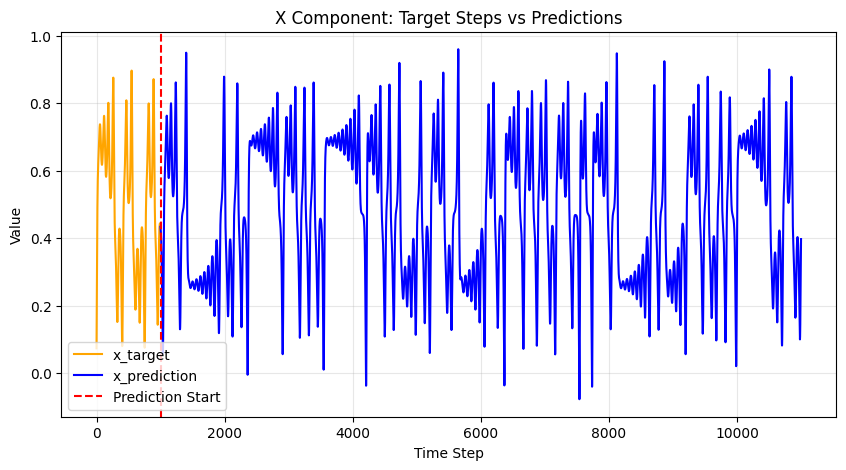

In [10]:
plt.figure(figsize=(10, 5))

attractor_samp_plot = attractor_samp[-1000:, 0].numpy()
plt.plot(attractor_samp_plot, label='x_target', color='orange')

# Plot predictions (blue) starting right after the attractor ends
prediction_start = len(attractor_samp_plot) - 1
plt.plot(range(prediction_start, prediction_start + len(predictions)), 
         predictions[:, 0].numpy(), label='x_prediction', color='blue')

# Add a vertical line to mark where predictions begin
plt.axvline(x=prediction_start, color='red', linestyle='--', label='Prediction Start')

plt.legend()
plt.title('X Component: Target Steps vs Predictions')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.show()

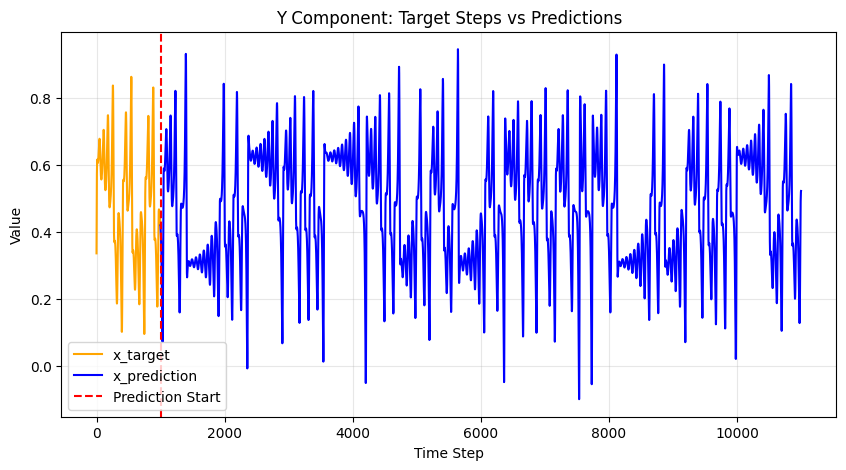

In [11]:
plt.figure(figsize=(10, 5))

attractor_samp_plot = attractor_samp[-1000:, 1].numpy()
plt.plot(attractor_samp_plot, label='x_target', color='orange')

prediction_start = len(attractor_samp_plot) - 1
plt.plot(range(prediction_start, prediction_start + len(predictions)), 
         predictions[:, 1].numpy(), label='x_prediction', color='blue')#pred Begins
#pred Begins line
plt.axvline(x=prediction_start, color='red', linestyle='--', label='Prediction Start')

plt.legend()
plt.title('Y Component: Target Steps vs Predictions')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.show()

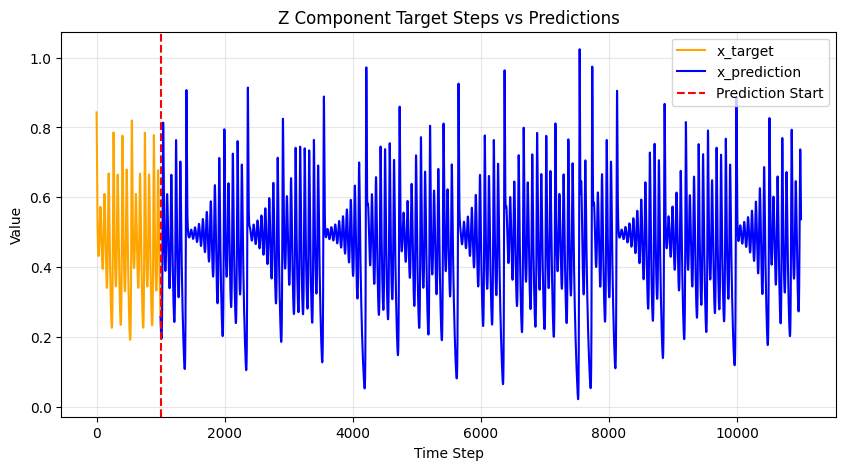

In [12]:
plt.figure(figsize=(10, 5))

attractor_samp_plot = attractor_samp[-1000:, 2].numpy()
plt.plot(attractor_samp_plot, label='x_target', color='orange')

prediction_start = len(attractor_samp_plot) - 1
plt.plot(range(prediction_start, prediction_start + len(predictions)), 
         predictions[:, 2].numpy(), label='x_prediction', color='blue')

# Pred Begins
plt.axvline(x=prediction_start, color='red', linestyle='--', label='Prediction Start')

plt.legend()
plt.title('Z Component Target Steps vs Predictions')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
from Models.Echostate import ESN

In [14]:
# Initialize ESN
ESNLorenz = Reservoir(
    input_dim=3, 
    reservoir_dim=1000, 
    output_dim=3, 
    spectral_radius=0.95, 
    leak_rate=0.3, 
    sparsity=0.9, 
    input_scaling=0.5
)

ESNLorenz.to(device)

Reservoir(
  (readout): Linear(in_features=1000, out_features=3, bias=True)
)

In [15]:
ESNLorenz.train_readout(inputs, targets, Warmup=200)
predictionsESN = ESNLorenz.predict(inputs, steps=10000)
predictionsESN = predictions.cpu().detach()
import plotly.graph_objects as go
# Create the figure
fig = go.Figure(data=[go.Scatter3d(
    x=predictions[:,0].numpy(), 
    y=predictions[:,1].numpy(), 
    z=predictions[:,2].numpy(),
    mode='lines',
    line=dict(
        color=predictions[:,2].numpy(),  # Color by z-value for depth
        colorscale='Viridis',            # Use a pretty colormap
        width=3,                         # Slightly thicker line
        showscale=True                   # Show color scale bar
    ),
    hoverinfo='none'                    # Cleaner hover
)])
# Update layout for better aesthetics
fig.update_layout(
    title={
        'text': 'Lorenz Attractor Trajectory',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=24, family='Arial')
    },
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis',
        xaxis=dict(gridcolor='rgb(200, 200, 200)', showbackground=True),
        yaxis=dict(gridcolor='rgb(200, 200, 200)', showbackground=True),
        zaxis=dict(gridcolor='rgb(200, 200, 200)', showbackground=True),
        bgcolor='rgb(240, 240, 240)',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=0.6)  # Better viewing angle
        )
    ),
    margin=dict(l=0, r=0, b=0, t=30),  # Tight margins
    paper_bgcolor='white',
    height=700,                        # Larger figure
    width=800
)
# Add annotations   
fig.update_layout(
    annotations=[
        dict(
            text=None,
            x=0.5,
            y=0.05,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=12)
        )
    ]
)
fig.show()